In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import get_dummies
import math

plt.style.use('ggplot')

In [2]:
from __future__ import print_function

import sys
from Bio.SeqUtils import ProtParamData  # Local
from Bio.SeqUtils import IsoelectricPoint  # Local
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Data import IUPACData
from Bio.SeqUtils import molecular_weight
from Bio import SeqIO
from Bio.SeqUtils import ProtParam

In [3]:
from sklearn import preprocessing

## Features from BioPython. Protein analysis

In [4]:
def analyse_scale_seq(data):
    mol_weight = []
    aromaticity = []
    instability_index = []
    isoelectric_point = []
    for i in data["sequence"]:
        X = ProtParam.ProteinAnalysis(i)
        mol_weight.append(X.molecular_weight())
        aromaticity.append(X.aromaticity())
        instability_index.append(X.instability_index())
        isoelectric_point.append(X.isoelectric_point())
    data["molecular_weight"] = mol_weight
    data["aromaticity"] = aromaticity
    data["instability_index"] = instability_index
    data["isoelectric_point"] = isoelectric_point
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(data[["molecular_weight","instability_index", "isoelectric_point"]])
    x_scaled = pd.DataFrame(x_scaled, columns=["molecular_weight","instability_index", "isoelectric_point"])
    data["molecular_weight"] = pd.DataFrame(x_scaled["molecular_weight"])
    data["instability_index"] = pd.DataFrame(x_scaled["instability_index"])
    data["isoelectric_point"] = pd.DataFrame(x_scaled["isoelectric_point"])

In [5]:
data_example = pd.read_csv("A0203.csv")
analyse_scale_seq(data_example)
data_example.tail()

,sequence,length,meas,netmhc,netmhcpan,smmpmbec_cpp,molecular_weight,aromaticity,instability_index,isoelectric_point
646,YVIKVSARV,9,89.949758,9.527962,8.184648,27.542287,0.384407,0.111111,0.152798,0.723513
647,YVVIAILTVV,10,20.989399,32.210688,109.395637,48.640721,0.464561,0.100000,0.312643,0.226121
648,YVVSRRGDL,9,19998.618696,1896.705921,7345.138682,990.831945,0.427954,0.111111,0.547741,0.584529
649,YVYFYDLSY,9,19998.618696,7979.946873,10814.339513,4159.106105,0.672481,0.555556,0.458056,0.034230
650,YWMGGTTYF,9,4226.686143,11587.773562,14288.939585,3250.872974,0.516749,0.444444,0.311370,0.226039


## Preprocessing. Scaling

In [6]:
data = pd.read_csv("Ext.csv", sep=",")
data.drop(["Unnamed: 0"], inplace=True, axis=1)
data.tail()

,sequence,length,meas,netmhc,netmhcpan,smmpmbec_cpp
2121,YVYPDNLPR,9,0.084693,0.120446,0.094057,0.280906
2122,YVYPDNLPV,9,0.898488,0.765906,0.785698,0.708660
2123,YWIREGKII,9,0.000000,0.080011,0.035959,0.086183
2124,YWMGGTTYF,9,0.350922,0.257071,0.220255,0.362626
2125,YYFSYPLFV,9,0.550114,0.668012,0.656733,0.675035


In [7]:
analyse_scale_seq(data)
data.tail()

,sequence,length,meas,netmhc,netmhcpan,smmpmbec_cpp,molecular_weight,aromaticity,instability_index,isoelectric_point
2121,YVYPDNLPR,9,0.084693,0.120446,0.094057,0.280906,0.548323,0.222222,0.231246,0.266668
2122,YVYPDNLPV,9,0.898488,0.765906,0.785698,0.708660,0.478572,0.222222,0.335037,0.046140
2123,YWIREGKII,9,0.000000,0.080011,0.035959,0.086183,0.598616,0.222222,0.090546,0.565215
2124,YWMGGTTYF,9,0.350922,0.257071,0.220255,0.362626,0.534869,0.444444,0.262926,0.232936
2125,YYFSYPLFV,9,0.550114,0.668012,0.656733,0.675035,0.624251,0.555556,0.292049,0.232856


In [ ]:
#it was done in R
from math import log
def logmeas(i):
    val = np.linspace(1, np.log(i)/np.log(50000))
    return 1 - min(val)

In [ ]:
"""def select_len(data, len):
    len_indexes = data['sequence'][data['length'] == len].index
    sel_len_X = data["sequence"][indexes]
    """

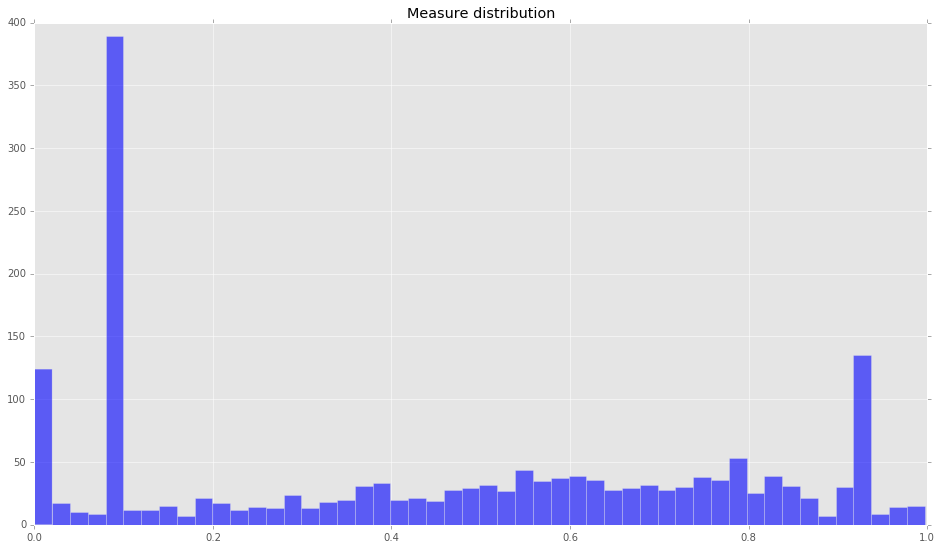

In [8]:
indexes = data['sequence'][data['length'] == 9].index
#indexes = data.index
selected_X = data["sequence"][indexes]

selected_y = pd.DataFrame(data['meas'][indexes])
selected_y['netmhc'] = pd.DataFrame(data['netmhc'][indexes])
selected_y['netmhcpan'] = pd.DataFrame(data['netmhcpan'][indexes])
selected_y['smmpmbec_cpp'] = pd.DataFrame(data['smmpmbec_cpp'][indexes])

plt.figure(figsize=(16,9))
plt.title("Measure distribution")
hh = plt.hist(selected_y['meas'], 50, color = 'blue', alpha = 0.6)

In [9]:
letters_X = selected_X.apply(list)
selected_X=pd.get_dummies(pd.DataFrame(list(letters_X)))

In [10]:
selected_X["molecular_weight"] = pd.DataFrame(data["molecular_weight"][indexes]).reset_index(drop=True)
selected_X["instability_index"] = pd.DataFrame(data["instability_index"][indexes]).reset_index(drop=True)
selected_X["isoelectric_point"] = pd.DataFrame(data["isoelectric_point"][indexes]).reset_index(drop=True)
selected_X["aromaticity"] = pd.DataFrame(data["aromaticity"][indexes]).reset_index(drop=True)

## SVR. 1Hot

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
mse_netmhc = mean_squared_error(selected_y["meas"], selected_y["netmhc"])
mse_netmhcpan = mean_squared_error(selected_y["meas"], selected_y["netmhcpan"])
mse_smmpmbec_cpp = mean_squared_error(selected_y["meas"], selected_y["smmpmbec_cpp"])

In [13]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [38]:
def SVR_res(train_x, test_x, train_y, test_y):
    
    """k=['rbf', 'linear','poly','sigmoid','precomputed']
    c= [1e-3, 1e0, 1e1, 1e2, 1e3]
    g=np.arange(1e-4,1e-2,0.0001)
    g=g.tolist()
    param_grid1=dict(kernel=k, C=c, gamma=g)  
    grid = GridSearchCV(SVR(), cv=5,param_grid=param_grid1,)
    grid.fit(train_x, train_y)   
    params = list(grid.best_params_.values())
    TunedSVR = SVR(kernel=params[0], C=params[1], gamma=params[2])
    TunedSVR.fit(train_x, train_y)"""
    TunedSVR = SVR(kernel='rbf', C=1, gamma=0.10000001)
    TunedSVR.fit(train_x, train_y)
    editedPredict = TunedSVR.predict(test_x)
    editedPredict = editedPredict.clip(min=0)
    editedPredict = editedPredict.clip(max=1)
    print("SVR MSE:", mean_squared_error(test_y, editedPredict))
    print("netmhc MSE:", mse_netmhc)
    print("netmhcpan MSE:", mse_netmhcpan)
    print("smmpmbec_cpp MSE:", mse_smmpmbec_cpp)
    plt.plot(editedPredict, test_y, 'ro')

In [39]:
random_number = 53
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y["meas"],
                                                test_size = 0.33, random_state = random_number)


SVR MSE: 0.0377751002332
netmhc MSE: 0.0289021865583
netmhcpan MSE: 0.0289280856635
smmpmbec_cpp MSE: 0.0331315186522


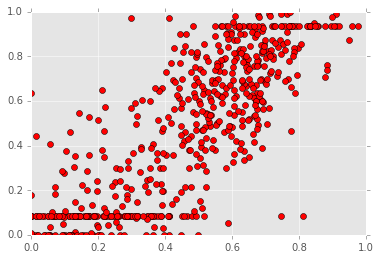

In [40]:
SVR_res(X_train, X_test, y_train, y_test)

## Kidera features

In [56]:
amino=pd.read_csv("acids.csv", sep=" ", index_col=False)
d = amino.to_dict(orient='list')
kidera_selected = selected_X.copy(deep=True)
f = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']
 
def kidera(pept):
    seq = list(pept)
    dim = len(seq)
    kidera = [0]*10
    for i in range(10):
        kidera[i] = [0]*dim
       
    for k in range(dim):
        for i in range(20):
            if seq[k] == d['amino'][i]:
                for j in range(10):
                    kidera[j][k] = d[f[j]][i]
   
    for i in range(10):
        kidera[i] = sum(kidera[i])/len(kidera[i])
   
    return kidera

In [57]:
for i,fact in enumerate(f): 
    data[fact]=[round(kidera(j)[i], 3) for j in data['sequence']]
    kidera_selected[fact] = pd.DataFrame(data[fact][indexes]).reset_index(drop=True)

## SVR. 1Hot + Kidera

In [59]:
random_number = 53
X_train, X_test, y_train, y_test = train_test_split(kidera_selected, selected_y["meas"],
                                                test_size = 0.33, random_state = random_number)


SVR MSE: 0.0374757953207
netmhc MSE: 0.0289021865583
netmhcpan MSE: 0.0289280856635
smmpmbec_cpp MSE: 0.0331315186522


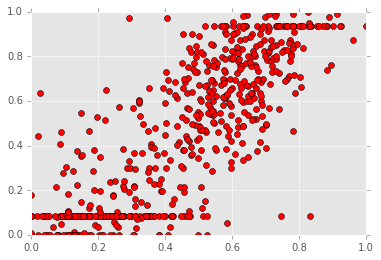

In [60]:
SVR_res(X_train, X_test, y_train, y_test)

## SVR. Kidera

In [68]:
kidera_only = kidera_selected[kidera_selected.columns[len(kidera_selected.columns)-14:len(kidera_selected.columns)]]

In [72]:
random_number = 53
X_train, X_test, y_train, y_test = train_test_split(kidera_only, selected_y["meas"],
                                                test_size = 0.33, random_state = random_number)


SVR MSE: 0.0775735051399
netmhc MSE: 0.0289021865583
netmhcpan MSE: 0.0289280856635
smmpmbec_cpp MSE: 0.0331315186522


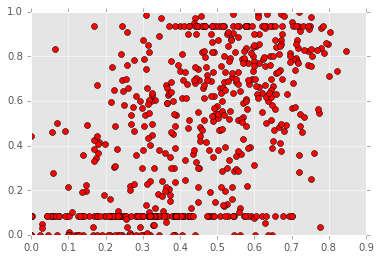

In [73]:
SVR_res(X_train, X_test, y_train, y_test)

In [74]:
#kidera sucks

## Word2Vec

C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `_import_array':
C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1455: undefined reference to `__imp_PyExc_ImportError'
C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1461: undefined reference to `__imp_PyExc_AttributeError'
C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1466: undefined reference to `__imp_PyCapsule_Type'
C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1467: undefined reference to `__imp_PyExc_RuntimeError'
C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1482: undefined reference to `__imp_PyExc_RuntimeError'
C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1490: undefined reference to `__imp_PyExc_RuntimeError'
C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h

00001	#include <Python.h>
00002	#include "theano_mod_helper.h"
00003	#include "structmember.h"
00004	#include <sys/time.h>
00005	
00006	#if PY_VERSION_HEX >= 0x03000000
00007	#include "numpy/npy_3kcompat.h"
00008	#define PyCObject_AsVoidPtr  NpyCapsule_AsVoidPtr
00009	#define PyCObject_GetDesc  NpyCapsule_GetDesc
00010	#define PyCObject_Check NpyCapsule_Check
00011	#endif
00012	
00013	#ifndef Py_TYPE
00014	#define Py_TYPE(obj) obj->ob_type
00015	#endif
00016	
00017	/**
00018	
00019	TODO: 
00020	- Check max supported depth of recursion
00021	- CLazyLinker should add context information to errors caught during evaluation. Say what node we were on, add the traceback attached to the node.
00022	- Clear containers of fully-useed intermediate results if allow_gc is 1
00023	- Add timers for profiling
00024	- Add support for profiling space used.
00025	
00026	
00027	  */
00028	static double pytime(const struct timeval * tv)
00029	{
00030	  struct timeval t;
00031	  if (!tv)
00032	    {
00033	 

Exception: Compilation failed (return status=1): C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `_import_array':. C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1455: undefined reference to `__imp_PyExc_ImportError'. C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1461: undefined reference to `__imp_PyExc_AttributeError'. C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1466: undefined reference to `__imp_PyCapsule_Type'. C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1467: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1482: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1490: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1496: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1506: undefined reference to `__imp_PyExc_RuntimeError'. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o:C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1518: more undefined references to `__imp_PyExc_RuntimeError' follow. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `NpyCapsule_Check':. C:/Users/Lev/Anaconda3/lib/site-packages/numpy/core/include/numpy/npy_3kcompat.h:454: undefined reference to `__imp_PyCapsule_Type'. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `unpack_list_of_ssize_t':. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:48: undefined reference to `__imp_PyExc_TypeError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:58: undefined reference to `__imp_PyExc_IndexError'. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `CLazyLinker_init':. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:352: undefined reference to `__imp_PyExc_IndexError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:370: undefined reference to `__imp_PyExc_IndexError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:385: undefined reference to `__imp_PyExc_IndexError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:389: undefined reference to `__imp_PyExc_IndexError'. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o:C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:393: more undefined references to `__imp_PyExc_IndexError' follow. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `CLazyLinker_init':. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:405: undefined reference to `__imp_PyExc_TypeError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:420: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:426: undefined reference to `__imp_PyExc_IndexError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:440: undefined reference to `__imp_PyExc_TypeError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:444: undefined reference to `__imp__Py_NoneStruct'. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `c_call':. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:546: undefined reference to `__imp__Py_NoneStruct'. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o:C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:546: more undefined references to `__imp__Py_NoneStruct' follow. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `lazy_rec_eval':. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:618: undefined reference to `__imp_PyExc_IndexError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:641: undefined reference to `__imp_PyExc_TypeError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:649: undefined reference to `__imp_PyExc_ValueError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:657: undefined reference to `__imp_PyExc_IndexError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:708: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:715: undefined reference to `__imp_PyExc_TypeError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:721: undefined reference to `__imp_PyExc_TypeError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:771: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:771: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:772: undefined reference to `__imp__Py_NoneStruct'. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `CLazyLinker_call':. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:807: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:807: undefined reference to `__imp__Py_NoneStruct'. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o:C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:808: more undefined references to `__imp__Py_NoneStruct' follow. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `CLazyLinker_call':. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:857: undefined reference to `__imp_PyExc_AssertionError'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:900: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:900: undefined reference to `__imp__Py_NoneStruct'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:901: undefined reference to `__imp__Py_NoneStruct'. C:\Users\Lev\AppData\Local\Temp\cc3Ry615.o: In function `CLazyLinker_set_allow_gc':. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:933: undefined reference to `__imp_PyBool_Type'. C:/Users/Lev/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-SP0-AMD64_Family_20_Model_2_Stepping_0_AuthenticAMD-3.5.2-64/lazylinker_ext/mod.cpp:936: undefined reference to `__imp__Py_TrueStruct'. collect2: ld returned 1 exit status. 